In [1]:
import math
import numpy as np
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from multiprocessing import Pool, cpu_count
import community  # Louvain algorithm package

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
features_df = pd.read_csv('extracted_features.csv', index_col='Unnamed: 0')
features_df.tail(10)

,area,perimeter,eccentricity,solidity,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,mean_intensity,std_intensity,label
3382,1.0,0.0,0.0,1.0,498.0,589.0,478.0,684.0,916.0,699.0,376.0,60528.0,0.076085,0.246714,ID192_A1_Regione-1.jp2-crop_slice_105/63_label...
3383,1.0,0.0,0.0,1.0,442.0,551.0,470.0,700.0,1007.0,656.0,361.0,60686.0,0.072734,0.239923,ID192_A1_Regione-1.jp2-crop_slice_105/25_label...
3384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/61_label...
3385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/8_label.tif
3386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/41_label...
3387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/1_label.tif
3388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/24_label...
3389,1.0,0.0,0.0,1.0,953.0,1243.0,1008.0,1327.0,1700.0,1264.0,860.0,55569.0,0.155621,0.335694,ID192_A1_Regione-1.jp2-crop_slice_105/59_label...
3390,1.0,0.0,0.0,1.0,1506.0,1704.0,1269.0,1509.0,1850.0,1439.0,1107.0,52680.0,0.212058,0.380376,ID192_A1_Regione-1.jp2-crop_slice_105/21_label...
3391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,ID192_A1_Regione-1.jp2-crop_slice_105/13_label...


In [4]:
features_df.loc[(features_df.iloc[:, :-1] != 0).any(axis=1)].tail(10)


,area,perimeter,eccentricity,solidity,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,mean_intensity,std_intensity,label
3361,1.0,0.0,0.0,1.0,709.0,882.0,609.0,799.0,863.0,733.0,470.0,59337.0,0.102928,0.288686,ID192_A1_Regione-1.jp2-crop_slice_105/16_label...
3369,1.0,0.0,0.0,1.0,801.0,936.0,714.0,914.0,1071.0,782.0,616.0,58385.0,0.117092,0.301273,ID192_A1_Regione-1.jp2-crop_slice_105/22_label...
3374,1.0,0.0,0.0,1.0,493.0,574.0,474.0,649.0,858.0,650.0,363.0,60703.0,0.074307,0.242381,ID192_A1_Regione-1.jp2-crop_slice_105/5_label.tif
3377,1.0,0.0,0.0,1.0,699.0,924.0,711.0,1078.0,1499.0,1077.0,644.0,57763.0,0.120400,0.302284,ID192_A1_Regione-1.jp2-crop_slice_105/3_label.tif
3379,1.0,0.0,0.0,1.0,579.0,702.0,549.0,650.0,738.0,605.0,471.0,60314.0,0.083208,0.258026,ID192_A1_Regione-1.jp2-crop_slice_105/50_label...
3381,1.0,0.0,0.0,1.0,634.0,807.0,571.0,607.0,786.0,697.0,504.0,59861.0,0.094836,0.277607,ID192_A1_Regione-1.jp2-crop_slice_105/23_label...
3382,1.0,0.0,0.0,1.0,498.0,589.0,478.0,684.0,916.0,699.0,376.0,60528.0,0.076085,0.246714,ID192_A1_Regione-1.jp2-crop_slice_105/63_label...
3383,1.0,0.0,0.0,1.0,442.0,551.0,470.0,700.0,1007.0,656.0,361.0,60686.0,0.072734,0.239923,ID192_A1_Regione-1.jp2-crop_slice_105/25_label...
3389,1.0,0.0,0.0,1.0,953.0,1243.0,1008.0,1327.0,1700.0,1264.0,860.0,55569.0,0.155621,0.335694,ID192_A1_Regione-1.jp2-crop_slice_105/59_label...
3390,1.0,0.0,0.0,1.0,1506.0,1704.0,1269.0,1509.0,1850.0,1439.0,1107.0,52680.0,0.212058,0.380376,ID192_A1_Regione-1.jp2-crop_slice_105/21_label...


In [ ]:
import pandas as pd
import networkx as nx
from itertools import combinations


if 'label' in features_df1.columns:
    features_df1 = features_df1.drop(columns=['label'])

# Create an empty graph
graph = nx.Graph()

# Add nodes to the graph with features as node attributes
for node_id, row in features_df1.iterrows():
    features = row.to_dict()
    graph.add_node(node_id, **features)

degree_centrality = nx.degree_centrality(graph)


def feature_similarity(feature_1, feature_2):
    return np.linalg.norm(np.array(list(feature_1.values())) - np.array(list(feature_2.values())))

# Iterate through unique pairs of nodes and add an edge if their feature similarity is above a threshold
threshold = 0.5 
for u, v in combinations(graph.nodes(), 2):
    similarity = feature_similarity(graph.nodes[u], graph.nodes[v])
    if similarity > threshold:
        graph.add_edge(u, v, weight=similarity)


#  Detect communities using Louvain algorithm
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(graph)

# Visualize the graph
import matplotlib.pyplot as plt
pos = nx.spring_layout(graph)
nx.draw(graph, pos=pos, with_labels=True)
plt.show()


In [5]:
# Create an empty undirected graph
G = nx.Graph()

In [8]:
# Add nodes to the graph with node attributes from the features_df DataFrame
for index, row in features_df.iterrows():
    node_id = index
    node_attributes = row.drop('label').to_dict()
    G.add_node(node_id, **node_attributes)


## Graph Analysis

In [9]:
node_degrees = dict(G.degree())
# node_degrees

In [10]:
from community import community_louvain

# Detect communities using Louvain method
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, name='community')

In [11]:
community_graph = nx.Graph()

In [12]:
# Aggregate nodes within each community and add them to the new graph
for community_id in set(partition.values()):
    nodes_in_community = [node for node in G.nodes if G.nodes[node].get('community') == community_id]
    community_graph.add_node(community_id, size=len(nodes_in_community))
    for node in nodes_in_community:
        community_graph.add_edge(community_id, node)

    # Add size attribute to nodes in community_graph
    community_graph.nodes[community_id]['size'] = len(nodes_in_community)

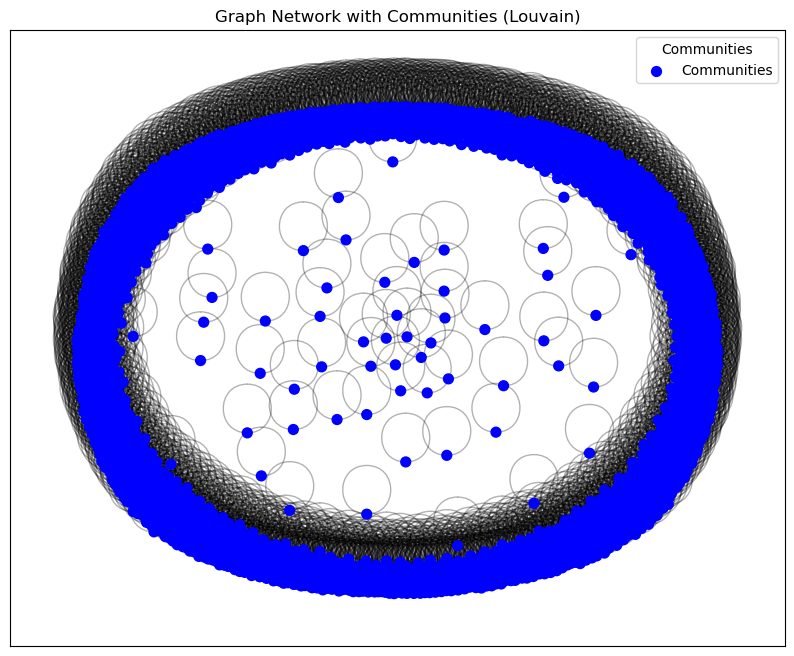

In [13]:
# Get community colors for visualization
# community_colors = [partition[node] for node in G.nodes()]

# Visualization using Matplotlib scatter plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
node_sizes = [community_graph.nodes[node]['size'] * 50 for node in community_graph.nodes]
nx.draw_networkx_nodes(community_graph, pos, node_color='blue', node_size=node_sizes, label='Communities')
nx.draw_networkx_edges(community_graph, pos, alpha=0.3)
plt.legend(title='Communities', loc='best')
plt.title('Graph Network with Communities (Louvain)')
# plt.axis('off')
plt.show()

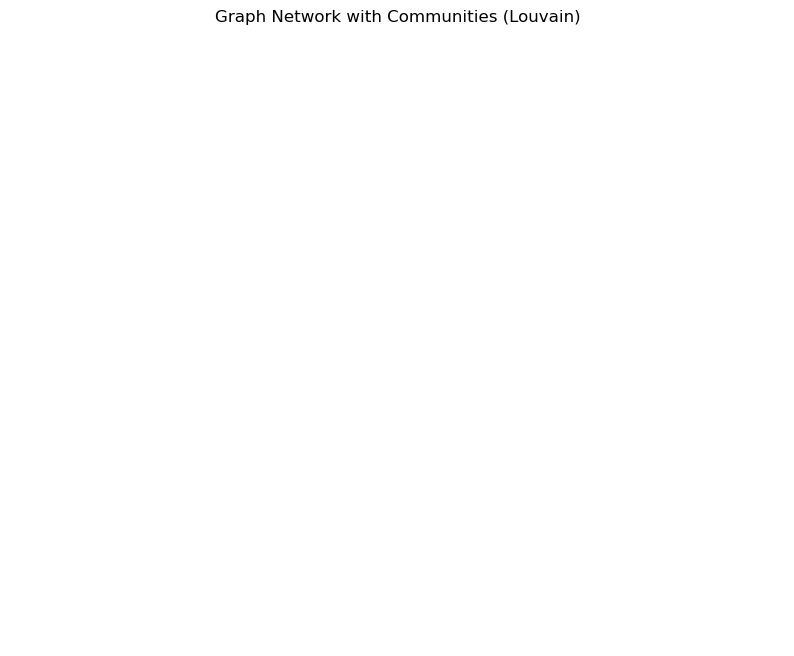

In [14]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Get community colors for visualization
community_colors = [partition[node] for node in G.nodes()]

node_sizes = [v * 50 for v in node_degrees.values()]
nx.draw_networkx_nodes(G, pos, node_color=community_colors, cmap='viridis', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, alpha=0.3)
# plt.legend(title='Communities', loc='best')

plt.title('Graph Network with Communities (Louvain)')
plt.axis('off')
plt.show()


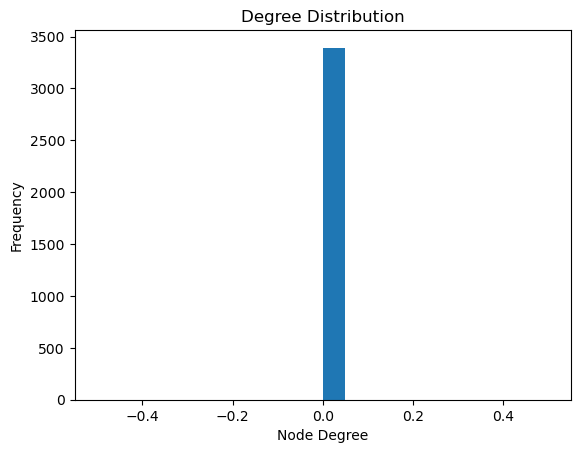

In [15]:
# Degree Distribution
degrees = dict(G.degree())
degree_values = list(degrees.values())
plt.hist(degree_values, bins=20)
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()


### Create a graph data structure to represent the cell network

In [22]:
mask_dir = 'data/bwmask/'

In [19]:
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

def extract_protein_information(mask_dir, batch_size=50, min_area_threshold=10000):
    mask_files = os.listdir(mask_dir)
    num_masks = len(mask_files)

    # Process masks sequentially
    for i in range(0, num_masks, batch_size):
        batch_mask_files = mask_files[i:i + batch_size]

        protein_info = []  # Clear protein_info after each batch

        for mask_file in batch_mask_files:
            mask_path = os.path.join(mask_dir, mask_file)
            image_name, _ = os.path.splitext(mask_file)

            # Use context manager for Image.open
            with Image.open(mask_path) as img:
                mask = np.array(img)

                # Perform connected component labeling
                labeled_mask = label(mask)

                # Calculate protein localization information
                for region in regionprops(labeled_mask):
                    if region.area >= min_area_threshold:  # Set a minimum area threshold to filter out noise
                        y, x = region.centroid
                        protein_info.append({
                            'image_name': image_name,
                            'protein_id': region.label,
                            'area': region.area,
                            'centroid_x': x,
                            'centroid_y': y,
                            'bbox': region.bbox
                        })

        # Identify interacting regions
        if len(protein_info) > 1:
            interacting_pairs = set()
            for i in range(len(protein_info)):
                for j in range(i + 1, len(protein_info)):
                    bbox_i = protein_info[i]['bbox']
                    bbox_j = protein_info[j]['bbox']
                    if do_boxes_intersect(bbox_i, bbox_j):
                        interacting_pairs.add((protein_info[i]['protein_id'], protein_info[j]['protein_id']))

            # Add interacting pairs to protein_info
            for pair in interacting_pairs:
                protein_info.append({
                    'image_name': image_name,
                    'protein_id': f'interaction_{pair[0]}_{pair[1]}',
                    'area': -1,  # Indicate that it's an interaction region
                    'centroid_x': -1,
                    'centroid_y': -1,
                    'bbox': (-1, -1, -1, -1)
                })

        # Use yield to return each batch's DataFrame
        df = pd.DataFrame(protein_info)
        yield df
        
def do_boxes_intersect(bbox1, bbox2):
    # Check if two bounding boxes intersect
    y1_min, x1_min, y1_max, x1_max = bbox1
    y2_min, x2_min, y2_max, x2_max = bbox2
    return not (x1_max < x2_min or x1_min > x2_max or y1_max < y2_min or y1_min > y2_max)

In [24]:
import networkx as nx

def create_cell_network_graph(protein_data):
    G = nx.Graph()

    # Add nodes to the graph
    for _, row in protein_data.iterrows():
        G.add_node(str(row['protein_id']), area=row['area'], centroid=(row['centroid_x'], row['centroid_y']))

    # Add edges for interacting pairs
    for _, row in protein_data.iterrows():
        if str(row['protein_id']).startswith('interaction_'):
            _, node1, node2 = str(row['protein_id']).split('_')
            G.add_edge(node1, node2)

    return G

In [25]:
protein_data = pd.concat(list(extract_protein_information(mask_dir, batch_size=64, min_area_threshold=50)))
cell_network_graph = create_cell_network_graph(protein_data)
print(cell_network_graph)

Graph with 180294 nodes and 126949 edges


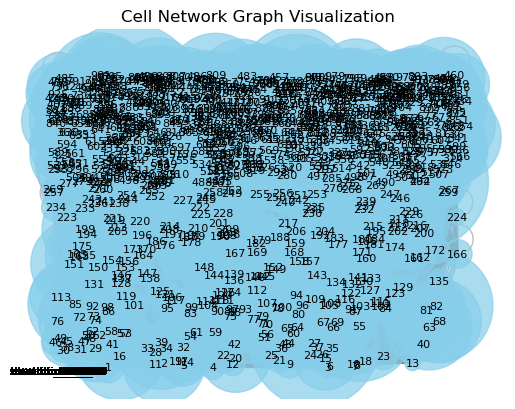

In [26]:
# Visualization of the cell_network_graph
pos = nx.get_node_attributes(cell_network_graph, 'centroid')  # Get positions of nodes

node_sizes = [data['area'] for node, data in cell_network_graph.nodes(data=True)]
nx.draw_networkx_nodes(cell_network_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)

nx.draw_networkx_edges(cell_network_graph, pos, edge_color='gray', alpha=0.5)
labels = {node: str(node) for node in cell_network_graph.nodes()}
nx.draw_networkx_labels(cell_network_graph, pos, labels, font_size=8, font_color='black')

# Set plot properties
plt.title("Cell Network Graph Visualization")
plt.axis('off')
plt.show()

# Network Analysis using Louvain Algorithm

In [27]:
from community import community_louvain
# import community as community_louvain  # Louvain algorithm package

partition = community_louvain.best_partition(cell_network_graph)

# Use NetworkX library to implement the Louvain algorithm for community detection
# Partition the cell network into communities (protein complexes)
# Analyze the communities to identify important nodes and pathways
# Analyze the communities

communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

# Print the communities
print(f"Identified Communities (Protein Complexes): {len(communities)}")

Identified Communities (Protein Complexes): 179316



# Network Visualization


#### Use NetworkX or other libraries like Matplotlib or Plotly to visualize the cell network
#### Visualize protein complexes as separate subgraphs or colors for better understanding


In [30]:
from tqdm import tqdm
import threading

# Get the number of protein complexes (communities)
num_communities = max(partition.values()) + 1

# Separate protein complexes into subgraphs based on community IDs
def _separate_protein_complexes(community_id):
    protein_complexes.append(cell_network_graph.subgraph([node for node in cell_network_graph.nodes if partition[node] == community_id]))

num_threads = 4
protein_complexes = []
threads = []

for community_id in tqdm(range(num_communities)):
    thread = threading.Thread(target=_separate_protein_complexes, args=(community_id,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()


TypeError: 'module' object is not callable

In [ ]:

def filter_nodes_by_degree(graph, threshold=50):
    degree_centrality = nx.degree_centrality(graph)
    important_nodes = {node for node, centrality in degree_centrality.items() if centrality > threshold}
    return important_nodes

def create_subgraph_for_community(graph, community_id):
    return graph.subgraph([node for node in graph.nodes if partition[node] == community_id])

def limit_cells_to_display(graph, num_cells_to_display):
    return sorted(graph.nodes(), key=lambda x: nx.degree(graph, x), reverse=True)[:num_cells_to_display]

def edge_bundling_edges(graph, cells_to_display):
    return [(u, v) for u, v in graph.edges() if u in cells_to_display and v in cells_to_display]

def get_node_sizes(graph, cells_to_display, important_nodes):
    node_sizes = []
    for node in cells_to_display:
        if node in important_nodes:
            node_data = graph.nodes[node]
            node_sizes.append(node_data['area'])
        else:
            node_sizes.append(30)  # A fixed size for non-important nodes
    return node_sizes


In [ ]:
# Function to visualize the cell network graph
def visualize_cell_network_graph(graph, cells_to_display, important_nodes, pos):
    node_sizes = get_node_sizes(graph, cells_to_display, important_nodes)

    nx.draw_networkx_nodes(graph, pos, nodelist=cells_to_display, node_size=node_sizes, node_color='skyblue', alpha=0.7)
    non_important_nodes_list = [node for node in cells_to_display if node not in important_nodes]
    nx.draw_networkx_nodes(graph, pos, nodelist=non_important_nodes_list, node_size=30, node_color='gray', alpha=0.7)

    edges = list(graph.edges)
    edge_positions = np.array([(pos[u], pos[v]) for u, v in edges], dtype='f')
    
    try:
        lc = LineCollection(edge_positions, colors='gray', linewidths=0.5, alpha=0.5)
        plt.gca().add_collection(lc)
    except NameError as e:
        print(f"{e}")

    plt.title("Cell Network Graph Visualization")
    plt.axis('off')
    plt.show()


In [29]:
import networkx as nx
import plotly.graph_objects as go

from concurrent.futures import ThreadPoolExecutor

def visualize_protein_complexes(cell_network_graph, protein_complexes, pos):
    num_communities = len(protein_complexes)
    colors = plt.cm.get_cmap('tab20', num_communities)

    fig = go.Figure()

    def visualize_complex(protein_complex, i):
        # Extract nodes and edges of the protein complex from the main graph
        nodes = [node for node in protein_complex.nodes() if node in cell_network_graph]
        edges = [edge for edge in cell_network_graph.edges() if edge[0] in nodes and edge[1] in nodes]

        # Create a subgraph for the protein complex
        complex_subgraph = nx.Graph()
        complex_subgraph.add_nodes_from(nodes)
        complex_subgraph.add_edges_from(edges)

        # Get positions of nodes in the subgraph
        complex_pos = {node: pos[node] for node in nodes}

        # Create a scatter plot for the nodes
        node_trace = go.Scatter(x=[], y=[], mode='markers', marker=dict(size=10, color=colors(i)))
        for node, (x, y) in complex_pos.items():
            node_trace['x'] += tuple([x])
            node_trace['y'] += tuple([y])
        fig.add_trace(node_trace)

        # Create a line plot for the edges
        edge_trace = go.Scatter(x=[], y=[], mode='lines')
        for u, v in complex_subgraph.edges():
            edge_trace['x'] += tuple([complex_pos[u][0], complex_pos[v][0], None])
            edge_trace['y'] += tuple([complex_pos[u][1], complex_pos[v][1], None])
        fig.add_trace(edge_trace)

    # Create a ThreadPoolExecutor to process the visualization of protein complexes in parallel
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(visualize_complex, protein_complex, i) for i, protein_complex in enumerate(protein_complexes)]
        for future in tqdm.tqdm(futures, total=len(futures)):
            future.result()

    # Set plot layout properties
    fig.update_layout(title_text="Protein Complexes Visualization", showlegend=False, xaxis=dict(showticklabels=False), yaxis=dict(showticklabels=False))
    fig.show()



In [ ]:

important_nodes = filter_nodes_by_degree(cell_network_graph, 50)
cells_to_display = limit_cells_to_display(cell_network_graph, 100)
pos = nx.get_node_attributes(cell_network_graph, 'centroid')


In [ ]:
visualize_cell_network_graph(cell_network_graph, cells_to_display, important_nodes, pos)

In [ ]:
from matplotlib.collections import LineCollection
visualize_cell_network_graph(cell_network_graph, cells_to_display, important_nodes, pos)

In [ ]:

visualize_protein_complexes(cell_network_graph, protein_complexes, pos)


In [ ]:
import tqdm
import concurrent.futures

def _get_cells_to_display():
    return cells_to_display

def draw_cell_network_with_protein_complexes(graph, partition, protein_complexes, num_cells_to_display, node_degree_threshold):
    
    # Get node sizes based on importance
    node_sizes = get_node_sizes(graph, cells_to_display, important_nodes)
    
    # Create subplots for main graph and protein complexes
    fig = make_subplots(rows=1, cols=2, subplot_titles=["Cell Network Graph", "Protein Complexes"])
    
    # Draw important nodes with their area as node size and color based on communities
    important_node_colors = [partition[node] for node in cells_to_display if node in important_nodes]
    
    # Create a function to iterate over the cells to display
    cells_to_display_function = _get_cells_to_display
    
    # Draw nodes and edges using multithreading
    with concurrent.futures.ThreadPoolExecutor() as executor:
        node_trace = go.Scatter(x=[], y=[], mode='markers', text=[], marker=dict(size=node_sizes, color=important_node_colors, colorscale='viridis', colorbar=dict(title='Community')))
        futures = [executor.submit(draw_node, node, node_trace) for node in tqdm.tqdm(cells_to_display_function())]
        concurrent.futures.wait(futures)
        
    fig.add_trace(node_trace, row=1, col=1)

    # Draw protein complexes as subgraphs with distinct colors
    colors = plt.cm.get_cmap('tab20', len(protein_complexes))
    for i, protein_complex in enumerate(protein_complexes):
        complex_x, complex_y = zip(*[pos[node] for node in protein_complex.nodes()])
        complex_trace = go.Scatter(x=complex_x, y=complex_y, mode='markers', marker=dict(size=10, color=[colors(i)]))
        fig.add_trace(complex_trace, row=1, col=2)

    # Set axis properties
    fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False, row=1, col=1)
    fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, row=1, col=1)
    fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False, row=1, col=2)
    fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, row=1, col=2)

    # Set layout properties
    fig.update_layout(title_text="Cell Network Graph with Protein Complexes (Limited Cells)", showlegend=False)
    fig.show()

def draw_node(node, node_trace):
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])


draw_cell_network_with_protein_complexes(cell_network_graph, partition, protein_complexes, num_cells_to_display=50, node_degree_threshold=0.05)


In [ ]:
import os
import networkx as nx
from PIL import Image
import numpy as np
from skimage.measure import label, regionprops

# Function to create the cell network graph
def create_cell_network_graph(image_path, mask_path, min_area_threshold=100, edge_threshold=0.05):
    # Load the image and mask
    img = Image.open(image_path)
    mask = Image.open(mask_path)

    # Convert the mask to a NumPy array
    mask_array = np.array(mask)

    # Segment cells from the mask and calculate region properties
    labeled_cells = label(mask_array)
    cell_properties = regionprops(labeled_cells)

    # Create a graph
    cell_network_graph = nx.Graph()

    # Dictionary to store centroid coordinates of nodes
    centroid_dict = {}

    # Add nodes (cells) to the graph
    for cell in cell_properties:
        if cell.area >= min_area_threshold:
            # Generate a unique node label as an integer
            node_label = cell.label
            cell_network_graph.add_node(node_label, area=cell.area)
            centroid_dict[node_label] = cell.centroid

    # Calculate pairwise distances between centroids
    num_cells = len(centroid_dict)
    centroids = np.array(list(centroid_dict.values()))
    distances = euclidean_distances(centroids, centroids)

    # Add edges (interactions) to the graph based on distance threshold
    for u, centroid_u in centroid_dict.items():
        for v, centroid_v in centroid_dict.items():
            if u != v and distances[u - 1, v - 1] <= edge_threshold:
                cell_network_graph.add_edge(u, v)

    # Print some graph information for debugging
    print("Number of nodes:", cell_network_graph.number_of_nodes())
    print("Number of edges:", cell_network_graph.number_of_edges())

    return cell_network_graph


In [ ]:
# Create the cell network graph
image_path = 'test_image/1-scimpanze-1dx-2sx_1_slice_4.png'
mask_path = 'test_image/1-scimpanze-1dx-2sx_1_slice_4_bwmask.png'


cell_network_graph = create_cell_network_graph1(image_path, mask_path)

In [ ]:
# Evaluate the cell network graph
def evaluate_cell_network_graph(graph):
    # Check if the graph has any edges
    if graph.number_of_edges() == 0:
        raise ValueError("The graph has no edges, and the modularity is undefined.")
        
    # Calculate modularity using Louvain algorithm for community detection
    partition = community.best_partition(graph)
    modularity = community.modularity(partition, graph)

    # Calculate overall connectivity and density
    connectivity = graph.number_of_edges()
    density = nx.density(graph)

    # Calculate robustness by simulating node removal
    num_nodes_removed = 10
    removed_nodes = np.random.choice(list(graph.nodes()), num_nodes_removed, replace=False)
    robustness = 0
    for node in removed_nodes:
        temp_graph = graph.copy()
        temp_graph.remove_node(node)
        if nx.is_connected(temp_graph):
            robustness += 1
    robustness /= num_nodes_removed

    # Calculate average path length and diameter
    avg_path_length = nx.average_shortest_path_length(graph)
    diameter = nx.diameter(graph)

    # Calculate clustering coefficient
    clustering_coefficient = nx.average_clustering(graph)

    return modularity, connectivity, density, robustness, avg_path_length, diameter, clustering_coefficient

In [ ]:

# Evaluate the cell network graph
modularity, connectivity, density, robustness, avg_path_length, diameter, clustering_coefficient = evaluate_cell_network_graph(cell_network_graph)

# Print the evaluation results
print("Modularity:", modularity)
print("Connectivity:", connectivity)
print("Density:", density)
print("Robustness:", robustness)
print("Average Path Length:", avg_path_length)
print("Diameter:", diameter)
print("Clustering Coefficient:", clustering_coefficient)